<a href="https://colab.research.google.com/github/alexlimatds/fact_extraction/blob/main/AILA2020/FACTS_AILA_SBERT_LaBSE_mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facts extraction with AILA data, SBERT (LaBSE) and mixup data

- for training:
  - the train dataset from AILA 2020. This can be obtained at https://github.com/Law-AI/semantic-segmentation;
  - augmented data generated with the mixup method.
- for test: additional train documents from AILA 2021;

There are two forms of evaluation: 5-fold cross-validation and with the test set. The data split of the cross-validation approach is done in terms of documents instead sentences.


### Notebook parameters

In [1]:
model_id = 'sentence-transformers/LaBSE'
augmented_data_dir = 'mixup_data_SBERT-LaBSE/'

###Installing dependencies

In [2]:
# SBERT
!pip install -U sentence-transformers

###Loading dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
g_drive_dir = "/content/gdrive/MyDrive/"
dataset_dir = 'fact_extraction_AILA/'

Mounted at /content/gdrive


In [4]:
!rm -r data
!mkdir data
!mkdir data/train
!tar -xf {g_drive_dir}{dataset_dir}train.tar.xz -C data/train
!mkdir data/test
!tar -xf {g_drive_dir}{dataset_dir}test.tar.xz -C data/test

train_dir = 'data/train/'
test_dir = 'data/test/'

In [5]:
import pandas as pd
from os import listdir
import csv

def read_docs(dir_name):
  """
  Read the docs in a directory.
  Params:
    dir_name : the directory that contains the documents.
  Returns:
    A dictionary whose keys are the names of the read files and the values are 
    pandas dataframes. Each dataframe has sentence and label columns.
  """
  docs = {} # key: file name, value: dataframe with sentences and labels
  for f in listdir(dir_name):
    df = pd.read_csv(
        dir_name + f, 
        sep='\t', 
        quoting=csv.QUOTE_NONE, 
        names=['sentence', 'label'])
    docs[f] = df
  return docs

docs_train = read_docs(train_dir)
docs_test = read_docs(test_dir)

print(f'TRAIN: {len(docs_train)} documents read.')
print(f'TEST: {len(docs_test)} documents read.')

TRAIN: 50 documents read.
TEST: 10 documents read.


### Loading aumented data
 
 The agumented data was generated in another notebook. Here, we just load it.
 
 There are several sets of augmented data  generated with different valus of alpha. Also, there are sets generated from the hole AILA dataset and sets generated following a division of cross-validation folds.



In [6]:
import numpy as np

augmented_data = {} # key: alpha (as string), value: (augmented vectos, augmented targets)
augmented_data_by_fold = {} # key: alpha (as string), value: dictionary where the keys are fold IDs and the values are lists [augmented vectos, augmented targets]
for f in listdir(g_drive_dir + dataset_dir + augmented_data_dir):
  if f.endswith('.npy'):
    f_data = np.load(g_drive_dir + dataset_dir + augmented_data_dir + f)
    alpha = f[6:9].replace('_', '.')
    if f.find('fold') != -1:
      temp_dic = augmented_data_by_fold.get(alpha, {})
      augmented_data_by_fold[alpha] = temp_dic
      temp_key = int(f[15:16]) # fold ID
    else:
      temp_dic = augmented_data
      temp_key = alpha
    t_data = temp_dic.get(temp_key, [None, None])
    if f.find('features') != -1: # feature data
      t_data[0] = f_data
    else: # target data
      t_data[1] = f_data
    temp_dic[temp_key] = t_data

###Features

In [7]:
from sentence_transformers import SentenceTransformer

sent_encoder = SentenceTransformer(model_id)
sent_encoder.max_seq_length = 512

In [8]:
n_features = sent_encoder.get_sentence_embedding_dimension()
print(f'Features dimension: {n_features}')

Features dimension: 768


In [9]:
import numpy as np

# Train features
train_features = None    # numpy matrix with shape (number of vectors, n_features)
train_labels = []       # list of strings (labels)
docs_train_features = {} # key: file id, value: numpy matrix of features
for doc_id, df in docs_train.items():
  features = sent_encoder.encode(df['sentence'].to_list())
  docs_train_features[doc_id] = features
  if train_features is None:
    train_features = features
  else:
    train_features = np.vstack((train_features, features))
  train_labels.extend(df['label'].tolist())

print(f'{train_features.shape[0]} sentences.')

9380 sentences.


In [10]:
# Test features
test_features = None    # numpy matrix with shape (number of vectors, n_features)
test_labels = []       # list of strings (labels)
for df in docs_test.values():
  if test_features is None:
    test_features = sent_encoder.encode(df['sentence'].to_list())
  else:
    test_features = np.vstack((test_features, sent_encoder.encode(df['sentence'].to_list())))
  test_labels.extend(df['label'].tolist())

test_features.shape

(1905, 768)

### Encoding / Decoding labels

In [11]:
def encode_label(labels):
  tensor = np.zeros((len(labels), 2))
  for i, str_label in enumerate(labels):
    if str_label == 'Facts':
      tensor[i,0] = 1 # [1,0]
    elif str_label == 'Other':
      tensor[i,1] = 1 # [0,1]
    else:
      raise ValueError('Unknown label: ', str_label)
  return tensor

def decode_vector_label(tensor):
  if tensor.shape[1] != 2:
    raise ValueError('Invalid tensor dimension: ', tensor.shape)
  labels = []
  for i in range(tensor.shape[0]):
    if tensor[i,0] == 1 and tensor[i,1] == 0:
      labels.append('Facts')
    elif tensor[i,1] == 1 and tensor[i,0] == 0:
      labels.append('Other')
    else:
      raise ValueError(f'Unknown value in the tensor at index {i}: {tensor[i][0]}')
  return labels

### Evaluation functions

In [12]:
# Reading the file containing the sets of trains documents and test documents by fold
train_files_by_fold = {}  # Key: fold ID, value: file names (list of string)
test_files_by_fold = {}   # Key: fold ID, value: file names (list of string)

df_folds = pd.read_csv(
  g_drive_dir + dataset_dir + 'train_docs_by_fold.csv', 
  sep=';', 
  names=['fold id', 'train', 'test'], 
  header=0)

for _, row in df_folds.iterrows():
  train_files_by_fold[row['fold id']] = row['train'].split(',')
  test_files_by_fold[row['fold id']] = row['test'].split(',')

for fold_id in train_files_by_fold.keys():
  print(f'Fold {fold_id}: \n\tTrain files: {train_files_by_fold[fold_id]} \n\tTest files: {test_files_by_fold[fold_id]}')


Fold 0: 
	Train files: ['d_44.txt', 'd_39.txt', 'd_12.txt', 'd_2.txt', 'd_7.txt', 'd_33.txt', 'd_16.txt', 'd_8.txt', 'd_42.txt', 'd_34.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_41.txt', 'd_46.txt', 'd_43.txt', 'd_50.txt', 'd_27.txt', 'd_25.txt', 'd_35.txt', 'd_45.txt', 'd_17.txt', 'd_48.txt', 'd_6.txt'] 
	Test files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt']
Fold 1: 
	Train files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_

In [13]:
def get_features_by_fold(fold_id):
  """
  Return the feature vectors and the respective labels of a specific cross-validation
  fold.
  Arguments:
    fold_id : the ID of the fold.
  Returns:
    The train feature vectors (numpy Matrix).
    The train labels (list of strings).
    The test feature vectors (numpy Matrix).
    The test labels (list of strings).
  """
  # train features
  train_features_fold = None
  train_labels_fold = []
  for doc_id in train_files_by_fold[fold_id]:
    if train_features_fold is None:
      train_features_fold = docs_train_features[doc_id]
    else:
      train_features_fold = np.vstack((train_features_fold, docs_train_features[doc_id]))
    train_labels_fold.extend(docs_train[doc_id]['label'].tolist())
  # test features
  test_features_fold = None
  test_labels_fold = []
  for doc_id in test_files_by_fold[fold_id]:
    if test_features_fold is None:
      test_features_fold = docs_train_features[doc_id]
    else:
      test_features_fold = np.vstack((test_features_fold, docs_train_features[doc_id]))
    test_labels_fold.extend(docs_train[doc_id]['label'].tolist())
  return train_features_fold, train_labels_fold, test_features_fold, test_labels_fold

def append_fold_augmented_data(alpha, fold_id, embeddings, targets):
  aug_data = augmented_data_by_fold[alpha][fold_id]
  appended_embeddings = np.vstack((embeddings, aug_data[0]))
  appended_targets = np.vstack((targets, aug_data[1]))
  return appended_embeddings, appended_targets

In [14]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support

def cross_validation(trainer, alpha_str):
  # Cross validation: for train, it uses augmented data + folder data. For test, it uses folder data only
  print(f'\n### Evaluation with cross-validation: alpha = {alpha_str} ###')
  train_metrics_cross = []
  test_metrics_cross = []
  for fold_id in train_files_by_fold.keys():
    print(f'Starting fold {fold_id}')
    # getting features and labels of the current fold
    train_features_fold, train_labels_fold, test_features_fold, test_labels_fold = get_features_by_fold(fold_id)
    # encoding labels as one-hot vectors
    train_targets_fold = encode_label(train_labels_fold)
    test_targets_fold = encode_label(test_labels_fold)
    # appending augmented data
    train_features, train_targets = append_fold_augmented_data(alpha_str, fold_id, train_features_fold, train_targets_fold)
    #training model
    model = trainer(train_features, train_targets)
    # test metrics
    predictions = model.predict(test_features_fold)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(
        test_labels_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    test_metrics_cross.append([p_test, r_test, f1_test])
    # train metrics
    predictions = model.predict(train_features_fold)
    p_train, r_train, f1_train, _ = precision_recall_fscore_support(
        train_labels_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    train_metrics_cross.append([p_train, r_train, f1_train])
  
  test_metrics_cross = np.array(test_metrics_cross)
  test_mean = np.mean(test_metrics_cross, axis=0)
  test_std = np.std(test_metrics_cross, axis=0)
  train_metrics_cross = np.array(train_metrics_cross)
  train_mean = np.mean(train_metrics_cross, axis=0)
  train_std = np.std(train_metrics_cross, axis=0)
  
  print(f'\nMean precision - std deviation => train: {train_mean[0]:.4f} {train_std[0]:.4f} \t test: {test_mean[0]:.4f} {test_std[0]:.4f}')
  print(f'Mean recall - std deviation    => train: {train_mean[1]:.4f} {train_std[1]:.4f} \t test: {test_mean[1]:.4f} {test_std[1]:.4f}')
  print(f'Mean f1 - std deviation        => train: {train_mean[2]:.4f} {train_std[2]:.4f} \t test: {test_mean[2]:.4f} {test_std[2]:.4f}')


In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_metrics = {}

def evaluate_with_test_set(trainer, alpha_str):
  print(f'\n### Evaluation with the test set: alpha = {alpha_str} ###')
  # coverting labels to one-hot vectors
  train_targets = encode_label(train_labels)
  test_targets = encode_label(test_labels)
  # using augmented data for training
  augmented_x, augmented_y = augmented_data[alpha_str]
  train_x = np.vstack((train_features, augmented_x))
  train_y = np.vstack((train_targets, augmented_y))
  # train
  model = trainer(train_x, train_y)
  # evaluation without augmented data
  predictions = model.predict(test_features)
  # Precision, Recall, F1
  t_metrics = precision_recall_fscore_support(
    test_labels, 
    predictions, 
    average='binary', 
    pos_label='Facts', 
    zero_division=0)
  metrics_entry = test_metrics.get(model.__class__.__name__, [])
  metrics_entry.append((t_metrics[0], t_metrics[1], t_metrics[2], alpha_str))
  test_metrics[model.__class__.__name__] = metrics_entry
  print(f'Precision: {t_metrics[0]:.4f}')
  print(f'Recall:    {t_metrics[1]:.4f}')
  print(f'F-score:   {t_metrics[2]:.4f}')
  # Confusion matrix
  cm = confusion_matrix(
    test_labels, 
    predictions)
  dm_display = ConfusionMatrixDisplay(cm, display_labels=['Other', 'Facts'])
  dm_display.plot()
  dm_display.ax_.set_title(f'alpha = {alpha_str}')


###Models

In [16]:
import torch

pu_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, inputs, targets, device):
    self.X = torch.from_numpy(inputs).float().to(device)
    self.y = torch.from_numpy(targets).float().to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

#### MLP

In [18]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import ShuffleSplit

torch.manual_seed(1)

class MLPTrainer:

  def __init__(self, model, device, l2_penalty=0.0001):
    self.model = model
    setattr(self.model.__class__, 'predict', self.predict)
    self.device = device
    self.model.to(device)
    # The training replicates the default configuration from scikit-learn's MLPClassifier
    self.criterion = torch.nn.CrossEntropyLoss().to(device)
    self.lambd = l2_penalty # weight decay for Adam optmizer
    self.n_epochs = 200

  def fit(self, inputs, targets, verbose=False):
    # early stopping params and variables
    tol = 0.001
    n_iter_no_change = 7
    early_stop_count = 0
    best_loss_validation = float("inf")
    # splitting train data into train and validation sets in order to perform early stopping
    spl = ShuffleSplit(n_splits=1, train_size=0.9, random_state=1)
    for train_index, val_index in spl.split(inputs):
      # getting datasets
      train_x = inputs[train_index]
      train_y = targets[train_index]
      validation_x = inputs[val_index]
      validation_y = targets[val_index]
      train_dl = DataLoader(
        MyDataset(train_x, train_y, self.device), 
        batch_size=64)
      validation_dl = DataLoader(
        MyDataset(validation_x, validation_y, self.device), 
        batch_size=len(validation_x))
      # training
      self.model.train()
      optimizer = Adam(
        self.model.parameters(), 
        weight_decay=self.lambd)
      for epoch in range(self.n_epochs):
        # iterate mini batches
        for x, y in train_dl:
          optimizer.zero_grad()
          yhat = self.model(x)
          loss = self.criterion(yhat, y)
          loss.backward()
          optimizer.step()
        # Early stopping
        for x, y in validation_dl:
          loss_validation = self.criterion(self.model(x), y)
        if loss_validation >= best_loss_validation - tol:
          early_stop_count += 1
        else:
          early_stop_count = 0
          best_loss_validation = loss_validation
        if early_stop_count == n_iter_no_change:
          break
    if verbose:
      print(f'TRAIN: Stopped at epoch {epoch + 1} {"(MAX EPOCH)" if epoch + 1 == self.n_epochs else ""}')

    self.model.eval()
    return self.model

  def predict(self, X):
    y = self.model.forward(torch.from_numpy(X).float().to(self.device))
    y_one_hot = torch.nn.functional.one_hot(torch.argmax(y, dim=1), num_classes=2)
    return decode_vector_label(y_one_hot.detach().to('cpu').numpy())

In [19]:
import torch.nn
from torch.nn.init import xavier_uniform_
from torch.nn.init import kaiming_uniform_

class TorchMLP(torch.nn.Module):
  def __init__(self, n_inputs, n_classes):
    super(TorchMLP, self).__init__()
    # hidden layer
    n_hidden_units = 100
    hidden1 = torch.nn.Linear(n_inputs, n_hidden_units)
    kaiming_uniform_(hidden1.weight, nonlinearity='relu')
    relu = torch.nn.ReLU()
    # output layer
    output = torch.nn.Linear(n_hidden_units, n_classes)
    xavier_uniform_(output.weight)
    # There's no need of softmax function because it's included in the CrossEntropyLoss function
    self.layers = torch.nn.Sequential(
      hidden1, 
      relu, 
      output)
  
  def forward(self, X):
    return self.layers(X)

In [20]:
def torch_mlp_trainer(X, y):
  trainer = MLPTrainer(
      TorchMLP(n_features, 2), 
      pu_device, 
      l2_penalty=0.0015)
  return trainer.fit(X, y, verbose=True)

In [21]:
%%time
for alpha_str in augmented_data.keys():
  cross_validation(
      torch_mlp_trainer, 
      alpha_str)



### Evaluation with cross-validation: alpha = 0.1 ###
Starting fold 0
TRAIN: Stopped at epoch 102 
Starting fold 1
TRAIN: Stopped at epoch 69 
Starting fold 2
TRAIN: Stopped at epoch 66 
Starting fold 3
TRAIN: Stopped at epoch 92 
Starting fold 4
TRAIN: Stopped at epoch 81 

Mean precision - std deviation => train: 0.7822 0.0174 	 test: 0.5384 0.0968
Mean recall - std deviation    => train: 0.8384 0.0171 	 test: 0.5724 0.0701
Mean f1 - std deviation        => train: 0.8091 0.0108 	 test: 0.5436 0.0294

### Evaluation with cross-validation: alpha = 0.5 ###
Starting fold 0
TRAIN: Stopped at epoch 69 
Starting fold 1
TRAIN: Stopped at epoch 79 
Starting fold 2
TRAIN: Stopped at epoch 79 
Starting fold 3
TRAIN: Stopped at epoch 80 
Starting fold 4
TRAIN: Stopped at epoch 82 

Mean precision - std deviation => train: 0.7845 0.0150 	 test: 0.5581 0.1012
Mean recall - std deviation    => train: 0.7938 0.0271 	 test: 0.5553 0.0963
Mean f1 - std deviation        => train: 0.7886 0.0093 	 test:


### Evaluation with the test set: alpha = 0.1 ###
TRAIN: Stopped at epoch 77 
Precision: 0.6468
Recall:    0.6452
F-score:   0.6460

### Evaluation with the test set: alpha = 0.5 ###
TRAIN: Stopped at epoch 53 
Precision: 0.6784
Recall:    0.6228
F-score:   0.6494

### Evaluation with the test set: alpha = 4.0 ###
TRAIN: Stopped at epoch 56 
Precision: 0.6667
Recall:    0.6154
F-score:   0.6400

### Evaluation with the test set: alpha = 1.0 ###
TRAIN: Stopped at epoch 56 
Precision: 0.6786
Recall:    0.6129
F-score:   0.6441
CPU times: user 1min 11s, sys: 2.74 s, total: 1min 14s
Wall time: 1min 14s


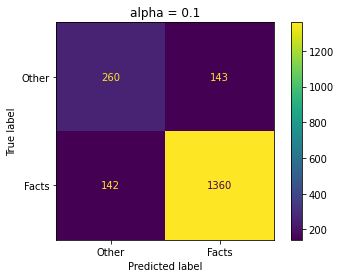

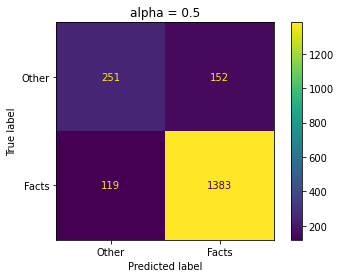

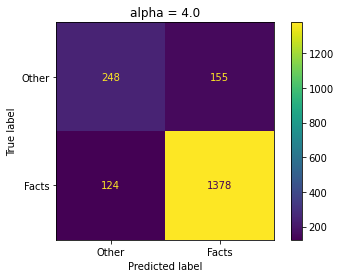

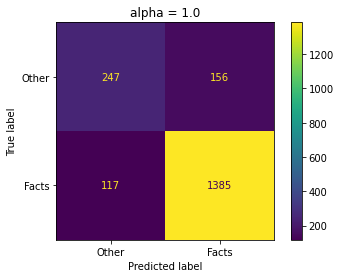

In [22]:
%%time
for alpha_str in augmented_data.keys():
  evaluate_with_test_set(
      torch_mlp_trainer, 
      alpha_str)


#### Logistic Regression

In [23]:
class TorchLogisticRegression(torch.nn.Module):
  def __init__(self, n_inputs, n_classes, device, verbose=False):
    super(TorchLogisticRegression, self).__init__()
    self.verbose = verbose
    self.device = device
    self.layer = torch.nn.Linear(n_inputs, n_classes)
    xavier_uniform_(self.layer.weight)

  def forward(self, X):
    return self.layer(X)
  
  def predict(self, X):
    y = self.forward(torch.from_numpy(X).float().to(self.device))
    y_one_hot = torch.nn.functional.one_hot(torch.argmax(y, dim=1), num_classes=2)
    return decode_vector_label(y_one_hot.detach().to('cpu').numpy())

  def fit(self, X, y):
    # SGD params
    learning_rate = 0.5
    momentum = 0.9
    lambda_param = 0.0001 # L2 regularization
    n_iterations = 1000
    decay_rate = 0.95  # learning rate decay
    # early stopping params and variables
    tol = 0.001
    n_iter_no_change = 5
    early_stop_count = 0
    best_loss = float("inf")
    # loss function and optmizer
    self.train()
    criterion = torch.nn.CrossEntropyLoss().to(self.device)
    optimizer = torch.optim.SGD(
      self.parameters(), 
      lr=learning_rate, 
      momentum=momentum, 
      weight_decay=lambda_param)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
      optimizer=optimizer, 
      gamma=decay_rate)
    # Data loader
    batch_size = 64
    train_dl = DataLoader(
      MyDataset(X, y, self.device), 
      batch_size=batch_size, 
      shuffle=True)
    # Train loop
    for i in range(1, n_iterations + 1):
      # iterate mini batches
      for x_batch, y_batch in train_dl:
        optimizer.zero_grad()
        y_hat = self(x_batch)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        optimizer.step()
      lr_scheduler.step()
      # early stop
      if loss >= best_loss - tol:
        early_stop_count += 1
      else:
        early_stop_count = 0
        best_loss = loss
      if early_stop_count == n_iter_no_change:
        break
    
    if self.verbose:
      print(f'TRAIN: Stopped at iteration {i} {"(MAX ITERATION)" if i == n_iterations else ""}')
    self.eval()
    return self


In [24]:
def torch_lr_trainer(X, y):
  lr_ = TorchLogisticRegression(n_features, 2, pu_device, verbose=True).to(pu_device)
  return lr_.fit(X, y)

In [25]:
%%time
for alpha_str in augmented_data.keys():
  cross_validation(
      torch_lr_trainer, 
      alpha_str)



### Evaluation with cross-validation: alpha = 0.1 ###
Starting fold 0
TRAIN: Stopped at iteration 15 
Starting fold 1
TRAIN: Stopped at iteration 10 
Starting fold 2
TRAIN: Stopped at iteration 16 
Starting fold 3
TRAIN: Stopped at iteration 15 
Starting fold 4
TRAIN: Stopped at iteration 14 

Mean precision - std deviation => train: 0.6407 0.0315 	 test: 0.5548 0.0989
Mean recall - std deviation    => train: 0.6391 0.0497 	 test: 0.5499 0.0793
Mean f1 - std deviation        => train: 0.6376 0.0168 	 test: 0.5407 0.0413

### Evaluation with cross-validation: alpha = 0.5 ###
Starting fold 0
TRAIN: Stopped at iteration 16 
Starting fold 1
TRAIN: Stopped at iteration 11 
Starting fold 2
TRAIN: Stopped at iteration 6 
Starting fold 3
TRAIN: Stopped at iteration 8 
Starting fold 4
TRAIN: Stopped at iteration 6 

Mean precision - std deviation => train: 0.6626 0.0315 	 test: 0.5684 0.0790
Mean recall - std deviation    => train: 0.5801 0.0667 	 test: 0.4986 0.0377
Mean f1 - std deviation   


### Evaluation with the test set: alpha = 0.1 ###
TRAIN: Stopped at iteration 12 
Precision: 0.6288
Recall:    0.6725
F-score:   0.6499

### Evaluation with the test set: alpha = 0.5 ###
TRAIN: Stopped at iteration 7 
Precision: 0.6340
Recall:    0.6104
F-score:   0.6220

### Evaluation with the test set: alpha = 4.0 ###
TRAIN: Stopped at iteration 7 
Precision: 0.6307
Recall:    0.6228
F-score:   0.6267

### Evaluation with the test set: alpha = 1.0 ###
TRAIN: Stopped at iteration 12 
Precision: 0.6434
Recall:    0.5955
F-score:   0.6186
CPU times: user 8.09 s, sys: 280 ms, total: 8.37 s
Wall time: 8.28 s


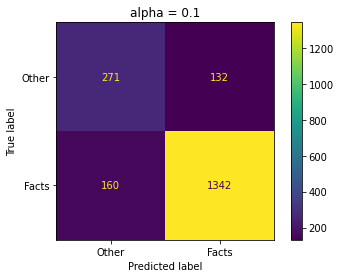

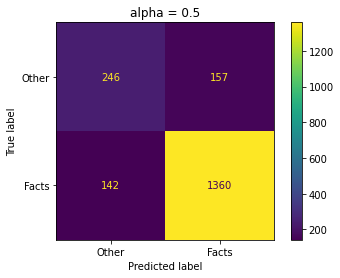

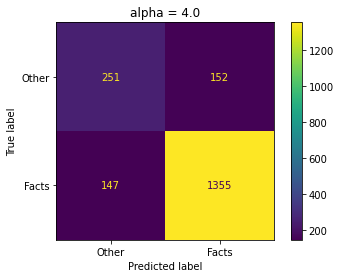

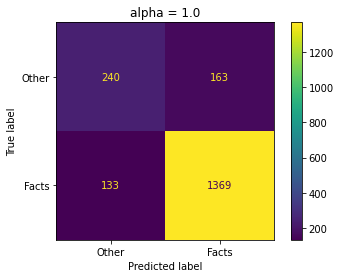

In [26]:
%%time
for alpha_str in augmented_data.keys():
  evaluate_with_test_set(
      torch_lr_trainer, 
      alpha_str)


### Results

In [27]:
from IPython.display import display, update_display

metrics_df = pd.DataFrame(columns=['Model', 'alpha', 'Precision', 'Recall', 'F1'])
for model_name, entries in test_metrics.items():
  for i, metrics in enumerate(entries):
    metrics_df.loc[i] = [model_name, metrics[3], f'{metrics[0]:.4f}', f'{metrics[1]:.4f}', f'{metrics[2]:.4f}']
metrics_display = display(metrics_df, display_id='metrics_table')

,Model,alpha,Precision,Recall,F1
0,TorchLogisticRegression,0.1,0.6288,0.6725,0.6499
1,TorchLogisticRegression,0.5,0.6340,0.6104,0.6220
2,TorchLogisticRegression,4.0,0.6307,0.6228,0.6267
3,TorchLogisticRegression,1.0,0.6434,0.5955,0.6186


### Reference paper:

> Paheli Bhattacharya, Shounak Paul, Kripabandhu Ghosh, Saptarshi Ghosh, and Adam Wyner. 2019. **Identification of Rhetorical Roles of Sentences in Indian Legal Judgments**. In Proc. International Conference on Legal Knowledge and Information Systems (JURIX).

